In order to view the maps correctly please visit the link :http://nbviewer.jupyter.org/
Start by importing some standard libraries for processing, as well as folium. We also verify that we have the right version.

In [3]:
import os
import numpy as np
import pandas as pd
import json
import folium
from branca.colormap import linear
folium.__version__ == '0.5.0'
pd.options.mode.chained_assignment = None  # default='warn'

from IPython.display import display, Math, Latex

## Task 1:

Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals](http://gisgeography.com/choropleth-maps-data-classification/) into data classes or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.


## Task 2:

Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

> *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.


 
## Answer to Task 2

In this section, we zoom in on Switzerland. The overall unemployment rate is $3\%$ as stated by the [Swiss Confederation website](https://www.amstat.ch/v2/index.jsp), but here we are interested in viewing the unemployment rates by cantons. In a second step, we will consider two sub-categories of job seekers - those who are currently employed and those who are not- and investigate the changes that these different definitions bring to the map of Switzerland.

### The data

The map of the Swiss cantons is represented by the `ch_Cantons TopoJson.Json` file, wher the objects are cantons , and are defined by a two letter id, a name and a list of arcs. 

As for the unemployment data, it is available for download in the Swiss Confederation Website under the section 'details'. We went under the category *2 Chomeurs et demandeurs d'emploi* , then * 2-1 taux de chômage * .
When asked to choose the desired variables to create the report, we selected the following : 
- current month
- Unemployment rate Indicators : unemployment rates 
- Unemployed Indicators : registered Unemployed 
- Job seekers indicators : employed Job seekers - Unemployed Job Seekers 
- Geographic characteristics : cantons and linguistic regions 

This is an overview of the dataframe we obtain: 

In [4]:
# read the .csv file. (it was modified as a text file to translate the headers to english)
df=pd.read_csv('U_R_CH_2.csv')
#drop the last line ( corresponds to the total ; not a canton)
df=df.drop(26)
df.head(5)

,Index,Canton,Unemployment_rate,Registered_unemployed,Job_seekers,Job_seekers_Employed
0,0,Zurich,3.3,27225,34156,6931
1,1,Berne,2.4,13658,18385,4727
2,2,Lucerne,1.7,3885,6756,2871
3,3,Uri,0.6,112,257,145
4,4,Schwyz,1.7,1455,2229,774


We notice that :
- The cantons are listed in the same order as in the map topoJson file (checked manually)
- The cantons are identified by their names, which are different from the ones used in the map topoJson file.
In order to correctly match the data to the map, we ought to use the cantons Id (e.g 'ZU', 'BE',...),which are not available in the dataframe. 
One easy way to solve this problem, is to extract a list of Ids from the map Topojson file and concatenate it to the dataframe. We emphasize on the fact that this operation is only possible because the order of the cantons are the same.

**Extracting the list of Ids from the map topojson file**


In [5]:
#load the topojson file as a dictionary.
cantons_geo_path = r'ch-cantons.topojson.json'
dic = json.load(open(cantons_geo_path))
#access the list of cantons in the file 
elements =dic['objects']['cantons']['geometries']
#here we can view the elements corresponding to Zurich, Bern and Luzern 
elements[0:3]

[{'arcs': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]],
  'id': 'ZH',
  'properties': {'name': 'Zürich'},
  'type': 'Polygon'},
 {'arcs': [[[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], [23], [24]],
   [[25, 26]],
   [[27]],
   [[28, 29]]],
  'id': 'BE',
  'properties': {'name': 'Bern/Berne'},
  'type': 'MultiPolygon'},
 {'arcs': [[-12, 30, 31, 32, 33, 34]],
  'id': 'LU',
  'properties': {'name': 'Luzern'},
  'type': 'Polygon'}]

In [18]:
# We will iterate on the elements of the list and extract their id, and store it in a new list "identification
identification = []
for d in elements:
    identification.append(d['id'])
# We add identification as a column to the dataframe
df['id']=identification
df.head(5)

,Index,Canton,Unemployment_rate,Registered_unemployed,Job_seekers,Job_seekers_Employed,id,percentage_Employed_Job_Seekers,percentage_Unemployed_Job_Seekers,difference
0,0,Zurich,3.3,27225,34156,6931,ZH,0.669642,2.630358,0.254582
1,1,Berne,2.4,13658,18385,4727,BE,0.617068,1.782932,0.346098
2,2,Lucerne,1.7,3885,6756,2871,LU,0.722425,0.977575,0.738996
3,3,Uri,0.6,112,257,145,UR,0.338521,0.261479,1.294643
4,4,Schwyz,1.7,1455,2229,774,SZ,0.590310,1.109690,0.531959


### Q-2.a
Now that we have a commun identification, we can match the unemployment rates to the catons on the map.
First,We extract a list from the dataframe that contains only the variable we need (`Unemply_rate`) and is indexed by the Ids.
We then create a blank map centered on Switzerland and import the palette we will use to color the cantons: We need
sequential palette where light colors corresponds to low employment rate and dark ones correspond to high employment rate. We chose a red-ish colormap since high employment rate tend to be a negative economic metric.


In [7]:
unemployment_dict = df.set_index('id')['Unemployment_rate']
unemployment_dict[0:5]

id
ZH    3.3
BE    2.4
LU    1.7
UR    0.6
SZ    1.7
Name: Unemployment_rate, dtype: float64

In [19]:
#create a blank map centered on Switzerland.
map_ch = folium.Map(location =[46.75, 8.25], zoom_start=6.5,tiles='Mapbox Bright')
#map_ch

In [20]:
#Importing the colors : 
import branca.colormap as cm


colormap = cm.linear.YlOrRd.scale(
    df.Unemployment_rate.min(),
    df.Unemployment_rate.max())

print(colormap(5.0))

colormap

#be0623


We can now create our choropleth map via the function `TopoJson` and an adequate style function.

In [21]:
folium.TopoJson(open('ch-cantons.topojson.json'),
                'objects.cantons',
                style_function=lambda feature: {
        'fillColor': colormap(unemployment_dict[feature['id']]),
#the color of each canton is proportional to the corresponding value presented in unemployment_dict 
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    },name='Unemployement rates'
               ).add_to(map_ch)

# we add a color scale 
colormap.caption = 'Unemployment color scale'
colormap.add_to(map_ch)

map_ch.save('CH_Unemployment_Rate1.html')
map_ch


We can see on this map that Geneva and Neuchatel have the highest unemployment rates $(>5.1)$.
On the other hand , Obwald and Uri have the lowest rates $(<0.7)$.
All in all, it seems that the unemployment rates are lower in the german  and Italian speaking parts than in the French speaking ones, with the exception of Zurich (only German speaking canton that reaches a rate above $3\%$). 

### Q-2.b

AS mentionned in the introduction, the unemployment rates are subject to various interpretations ,depending on the way they are defined.Until now, we have been considering the following definition:

$$
\text{Rate} = 100* \frac{\text{Job Seekers}}{\text{Active population}}
$$
However, the dataframe shows that there are two types of job seekers: those who currently have a job and are looking for a new one, and those who are not employed at the moment.
As we can easily check, the sum of the two columns gives us the total number of job seekers.
We will compute the proportion of each category and include it to our dataframe.
\begin{align}
\text{Percentage_Unemployed_Job_Seekers}&= 100\times \frac{\text{Unemployed Job Seekers}}{\text{Active population}}\\
&=100 \times  \frac{\text{Job Seekers}}{\text{Active population}}\times \frac{\text{Unemployed Job Seekers}}{\text{Job Seekers}} \\
&=\text{Unemployment rate }\times \frac{\text{Unemployed Job Seekers}}{\text{Job Seekers}}
\end{align}


In [11]:

#df.Registered_unemployed+df.Job_seekers_Employed==df.Job_seekers

df['percentage_Employed_Job_Seekers']=df.Unemployment_rate*df.Job_seekers_Employed/df.Job_seekers
df['percentage_Unemployed_Job_Seekers']=df.Unemployment_rate*df.Registered_unemployed/df.Job_seekers
df.head(4)

,Index,Canton,Unemployment_rate,Registered_unemployed,Job_seekers,Job_seekers_Employed,id,percentage_Employed_Job_Seekers,percentage_Unemployed_Job_Seekers
0,0,Zurich,3.3,27225,34156,6931,ZH,0.669642,2.630358
1,1,Berne,2.4,13658,18385,4727,BE,0.617068,1.782932
2,2,Lucerne,1.7,3885,6756,2871,LU,0.722425,0.977575
3,3,Uri,0.6,112,257,145,UR,0.338521,0.261479


In order to create two new choropleth maps viewing these results, we follow the same steps as previously. In order to avoid repetition, we define a function `add_layer_toMap`: Given the name of the chosen column, this function will add it as a layer to the map.
In this part, we define the colormap differently, using the quantiles of the chosen variable in order to help with the interpretation.

In [12]:
def add_layer_toMap (definition,name_control):
    #first parameter definition : name of the column we want to represent
    #second parameter name_control: the name to be used in the layer control panel 
    dic_definition = df.set_index('id')[definition]
    colormap_definition =cm.linear.OrRd.to_step(
    n=4,
    data=df[definition],
    method='quantiles')
     #linear.OrRd.scale(df[definition].min(),df[definition].max())
    folium.TopoJson(open('ch-cantons.topojson.json'),'objects.cantons',
                    style_function=lambda feature: {
                        'fillColor': colormap_definition(dic_definition[feature['id']]),
                        'color': 'black','weight': 1,'dashArray': '5, 5','fillOpacity': 0.9,
                    },name=name_control,
                   ).add_to(map_ch)
    colormap_definition.caption = name_control
    colormap_definition.add_to(map_ch)
    return map_ch


In [13]:
# create a blank map
map_ch = folium.Map(location =[46.75, 8.25],tiles='Mapbox Bright', zoom_start=6.5)
#view the map with the initial unemployment rate 
add_layer_toMap('Unemployment_rate','Unemployement rate (%)')
map_ch.save('CH__Unemployment_Rate2.html')
map_ch 

This is the same map as previously,where the colors are assigned differently: this highlights the cantons where the unemployment rate is above the 75% quantile . The difference between the different linguistic parts of Switzerland is also more saliant.

In [14]:
# create a blank map
map_ch = folium.Map(location =[46.75, 8.25],tiles='Mapbox Bright', zoom_start=6.5)
#add a layer corresponding to the percentage of unemployed job seekers 
add_layer_toMap('percentage_Unemployed_Job_Seekers','Unemployed Job seekers (%)')
map_ch.save('CH_Unemployed_Job_seekers.html')
map_ch


We can say that the proportions of unemployed job seekers follows roughtly the same trend as the total proportion of job seekers, although their distributions are shifted by $1\%$. 
As before, the french speaking part and Zurich are above the $75\%$ quantile . 
Tessin, however, is closer to the median according to this definition.


In [15]:
# create a blank map
map_ch = folium.Map(location =[46.75, 8.25],tiles='Mapbox Bright', zoom_start=6.5)
#add a layer corresponding to the percentage of unemployed job seekers 
add_layer_toMap('percentage_Employed_Job_Seekers','Employed Job seekers (%)')
map_ch.save('CH_Employed_Job_seekers.html')
map_ch


This map shows the proportion of employed job seekers. These are globally lower than the counterpart - unemployed job seekers. Still, they are higher than $1.2\%$ in the French speaking part, Schaffhouse ,Basel-Stadt and Tessin.

### Unemployed /Employed job seekers ratio accross the cantons

Finally, we can summarize the variation between employed and unemployed job seekers by representing their ratio in each canton.

In [16]:
#create a blank map
map_ch = folium.Map(location =[46.75, 8.25],tiles='Mapbox Bright', zoom_start=6.5)
#define the ratio 
df['difference']= df.Job_seekers_Employed/df.Registered_unemployed
dic_definition = df.set_index('id')['difference']
# Here we use a diverging colors : red for ratio<1 and red for ratio >1
colormap_definition=cm.linear.RdYlBu.scale(dic_definition.min(),dic_definition.max())

In [17]:
folium.TopoJson(open('ch-cantons.topojson.json'),'objects.cantons',style_function=lambda feature: {
    'fillColor': colormap_definition(dic_definition[feature['id']]),
    'color': 'black','weight': 1,'dashArray': '5, 5','fillOpacity': 0.9,}).add_to(map_ch)
colormap_definition.caption = 'Employed Job Seekers / Unemployed Job Seekers '
colormap_definition.add_to(map_ch)
map_ch

In this map, blue regions have a higher proportion of employed job seekers than unemployed ones.

This confirms that job seekers in the french speaking parts of Switzerland tend to be unemployed when looking for a job. Obwald	,Uri and Grissons have the highest ratio, meaning that the number of employed job seekers are roughtly $1.3$ times larger than the number of unemployed job seekers.

The ratio varies accross the Italian and the German speaking cantons, however we see here again that Zurich follows the same trend as the French speaking regions.

## Task 3:

Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

## Answer to Task 3
### the data

Similarly to the second task, the data has been collected from the Swiss Confederation Website under the section 'details'.
In order to analyze the difference between Swiss and Foreign nationals , we selected the following indicators: 
- current month
- Unemployment rate Indicators : unemployment rates 
- Various employment indicators 
- Geographic characteristics : cantons and linguistic regions
- other attributes : Nationality
the first time and age category the second time(We can only choose one at a time)

We proceed the same way to build a dataframe representing the variation of unemployment rates according to age, choosing *class age* instead of *nationality* in the *other attribute* list.

**Step 1:** Read the data from the CSV

In [6]:
df=pd.read_csv('../rate_Canton_Nationality')
df.dtypes
df=df.drop(52)
df.head()

,Index,region,Canton,Nationality,Unemploy_rate,Unemploy_rate_Young,Registered_unemployed,Young_Unemployed,Long_period_unemployed,Job_seekers,Job_seekers_Employed
0,0,Suisse alémanique,Zurich,Etrangers,5.3,5.8,12111,1015,2106,15384,3273
1,1,Suisse alémanique,Zurich,Suisses,2.5,3.2,15114,2405,2647,18772,3658
2,2,Suisse alémanique,Berne,Etrangers,5.5,7.7,4900,597,848,6859,1959
3,3,Suisse alémanique,Berne,Suisses,1.8,2.2,8758,1406,1488,11526,2768
4,4,Suisse alémanique,Lucerne,Etrangers,3.9,4.7,1593,217,181,2902,1309


In order to plot maps, we need some setup:

In [7]:
init_coords =[46.819, 8.223]
cantons_geo_path = r'ch-cantons.topojson.json'
geo_json_data = json.load(open(cantons_geo_path))

dic=dict(geo_json_data)
liste =dic['objects']['cantons']['geometries']
identification = []
for d in liste:
    identification.append(d['id'])

**Step 2:** We plot the choropleth for unemployment rates of Swiss nationals

In [8]:
df_swissmap = df[df.Nationality != "Etrangers"]
df_swissmap.head()

suisses_map = folium.Map(location=init_coords, tiles='cartodbpositron', zoom_start=7)



df_swissmap['id']=identification

swiss_dict = df_swissmap.set_index('id')['Unemploy_rate']


colormap = linear.OrRd.scale(0,df_swissmap.Unemploy_rate.max())

folium.TopoJson(open('ch-cantons.topojson.json'),
                'objects.cantons',
                style_function=lambda feature: {
                    'fillColor': colormap(swiss_dict[feature['id']]),
                    'color': 'black',
                    'weight': 1,
                    'dashArray': '5, 5',
                    'fillOpacity': 0.8,
                },name='Unemployement rates'
               ).add_to(suisses_map)

colormap.caption = 'Unemployement rates of Swiss people in Switzerland (%)'
colormap.add_to(suisses_map)
suisses_map



**Step 3:** We plot the choropleth for unemployment rates of foreign nationals

In [5]:
df_foreignermap = df[df.Nationality != "Suisses"]
df_foreignermap.head()

etranger_map = folium.Map(location=init_coords, tiles='cartodbpositron', zoom_start=7)

df_foreignermap['id']=identification

etranger_dict = df_foreignermap.set_index('id')['Unemploy_rate']


colormap_f = linear.OrRd.scale(0,df_foreignermap.Unemploy_rate.max())

folium.TopoJson(open('ch-cantons.topojson.json'),
                'objects.cantons',
                style_function=lambda feature: {
                    'fillColor': colormap_f(etranger_dict[feature['id']]),
                    'color': 'black',
                    'weight': 1,
                    'dashArray': '5, 5',
                    'fillOpacity': 0.8,
                },name='Unemployement rates'
               ).add_to(etranger_map)

colormap_f.caption = 'Unemployement rates of Foreigners in Switzerland (%)'
colormap_f.add_to(etranger_map)
etranger_map



**Step 4:** We plot the choropleth for showing the difference between Swiss and Foreign unemployment rates

In [6]:
df1 = df.copy()
df1['diffs'] = df1.groupby(['Canton'])['Unemploy_rate'].diff()
df1.sort_index(inplace=True)
df1.head(20)

df_diffmap = df1[np.isfinite(df1['diffs'])]
df_diffmap['unemployment_diff'] = 0
df_diffmap['unemployment_diff'][(df_diffmap['Nationality'] == 'Etrangers')] = -1*df_diffmap['diffs']
df_diffmap['unemployment_diff'][(df_diffmap['Nationality'] == 'Suisses')] = df_diffmap['diffs']
df_diffmap.head()

diff_map = folium.Map(location=init_coords, tiles='cartodbpositron', zoom_start=7)
df_diffmap['id']=identification
diff_dict = df_diffmap.set_index('id')['unemployment_diff']
x = max(abs(df_diffmap.unemployment_diff.min()),abs(df_diffmap.unemployment_diff.max()))

colormap_d = linear.RdBu.scale(-x,x)
folium.TopoJson(open('ch-cantons.topojson.json'),
                'objects.cantons',
                style_function=lambda feature: {
                    'fillColor': colormap_d(diff_dict[feature['id']]),
                    'color': 'black',
                    'weight': 1,
                    'dashArray': '5, 5',
                    'fillOpacity': 0.8,
                },name='Unemployement rates'
               ).add_to(diff_map)

colormap_d.caption = 'Difference in unemployment rates of Foreigners and Swiss people in Switzerland (%)'
colormap_d.add_to(diff_map)
diff_map

**Step 5:** Now we look at the breakdown by age

In [7]:
#importing libaries and setting style
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('cubehelix',26)

def clean(x):
    if x =="...":
        return float(0)
    else:
        return float(x)

dfx=pd.read_csv('../rate_Canton_Age.csv')
dfx.dtypes
dfx = dfx.drop(260)
df_age = dfx.drop(['Unnamed: 0','Unemployement_Rate_young', 'Registered_unemployed','Unemployed_Young','Unemployed_Long_Period','Job_seekers','Job_seekers_Employed','Region'], axis=1)
df_age['Unemployement_Rate']=df_age['Unemployement_Rate'].apply(lambda x : clean(x))
df_age.head()

,Canton,Age_Category,Unemployement_Rate
0,Zurich,15-19 ans,3.9
1,Zurich,20-24 ans,3.7
2,Zurich,25-29 ans,3.5
3,Zurich,30-34 ans,3.7
4,Zurich,35-39 ans,3.8


In [14]:
df_pivoted_age = df_age.reset_index().pivot(index='Age_Category', columns='Canton', values='Unemployement_Rate')
df_pivoted_age

Canton,Appenzell Rhodes-Extérieures,Appenzell Rhodes-Intérieures,Argovie,Berne,Bâle-Campagne,Bâle-Ville,Fribourg,Genève,Glaris,Grisons,...,Schwyz,Soleure,St-Gall,Tessin,Thurgovie,Uri,Valais,Vaud,Zoug,Zurich
Age_Category,,,,,,,,,,,,,,,,,,,,,
15-19 ans,0.6,0.0,2.2,2.2,1.7,5.4,2.2,2.2,1.2,1.0,...,1.3,2.6,2.0,4.7,2.0,0.4,2.5,2.4,1.4,3.9
20-24 ans,2.0,1.6,3.9,3.1,3.9,4.1,3.7,5.4,2.2,1.6,...,1.7,3.1,2.6,5.4,2.5,0.6,3.8,5.1,2.1,3.7
25-29 ans,2.3,0.4,3.6,3.0,3.6,3.8,3.2,7.2,2.2,1.3,...,1.4,3.0,2.8,3.7,2.7,0.8,3.5,5.5,2.3,3.5
30-34 ans,1.7,0.0,3.4,2.9,3.6,4.2,3.2,6.6,2.0,1.2,...,1.7,3.4,2.5,3.6,2.2,0.6,3.2,5.3,2.6,3.7
35-39 ans,1.6,0.0,3.2,2.8,3.0,3.7,2.9,5.9,1.5,1.2,...,1.4,2.6,2.4,2.7,2.3,0.5,3.1,4.7,2.4,3.8
40-44 ans,1.5,0.2,2.5,2.0,2.3,3.7,2.3,5.2,1.6,0.7,...,1.7,2.0,1.9,2.4,1.6,0.3,2.3,4.1,2.4,3.2
45-49 ans,1.5,0.4,2.3,2.0,2.2,2.8,2.0,4.4,1.5,0.8,...,1.6,1.9,1.5,2.3,1.4,0.6,2.2,3.8,2.1,2.9
50-54 ans,1.9,0.5,2.7,2.1,2.2,2.8,2.7,4.4,1.7,1.0,...,1.6,2.3,1.9,2.9,1.7,0.6,2.4,3.9,2.6,3.1
55-59 ans,1.9,0.0,2.8,2.2,2.7,3.0,2.4,4.0,2.3,1.0,...,2.3,2.8,2.2,3.3,2.1,0.9,2.5,3.9,2.3,3.2


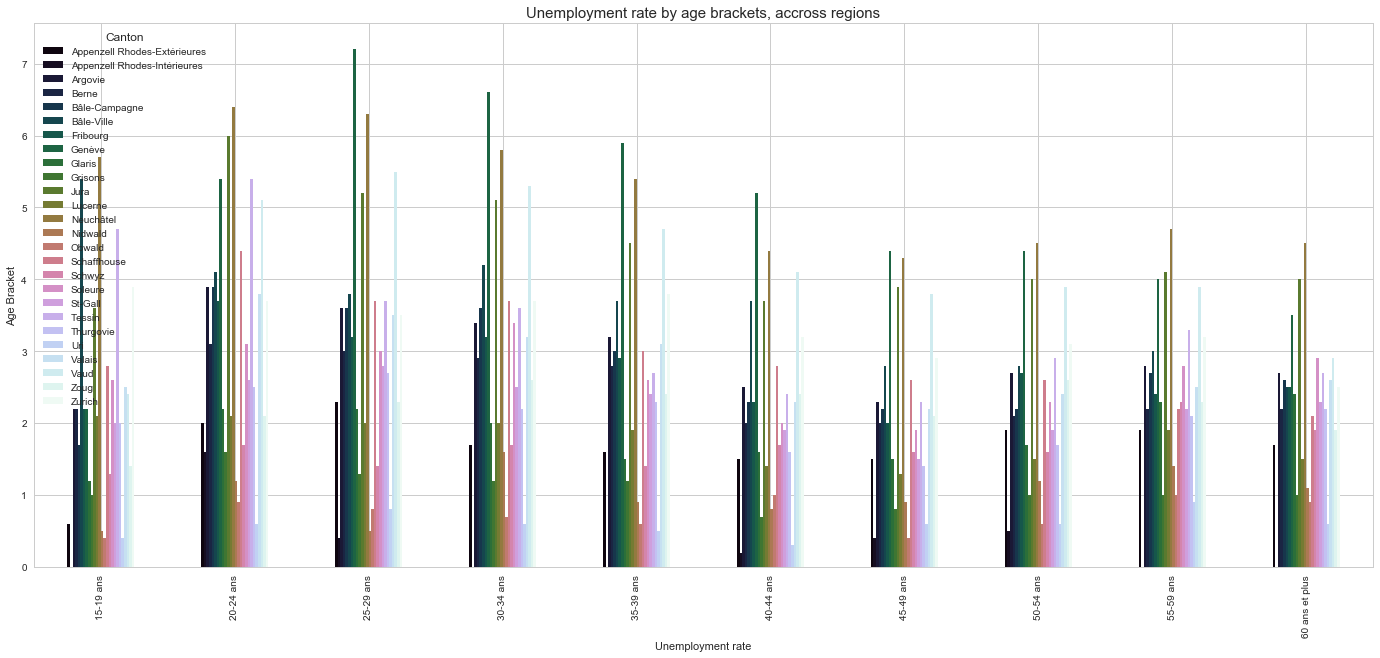

In [9]:
#Plotting and adding info
df_pivoted_age.plot.bar(figsize=(24,10))

plt.title('Unemployment rate by age brackets, accross regions',fontsize=15)
plt.ylabel('Age Bracket')
plt.xlabel('Unemployment rate')
plt.show()

In [10]:
df_pivoted_age = df_age.reset_index().pivot(index='Canton', columns='Age_Category', values='Unemployement_Rate')
df_pivoted_age

Age_Category,15-19 ans,20-24 ans,25-29 ans,30-34 ans,35-39 ans,40-44 ans,45-49 ans,50-54 ans,55-59 ans,60 ans et plus
Canton,,,,,,,,,,
Appenzell Rhodes-Extérieures,0.6,2.0,2.3,1.7,1.6,1.5,1.5,1.9,1.9,1.7
Appenzell Rhodes-Intérieures,0.0,1.6,0.4,0.0,0.0,0.2,0.4,0.5,0.0,0.0
Argovie,2.2,3.9,3.6,3.4,3.2,2.5,2.3,2.7,2.8,2.7
Berne,2.2,3.1,3.0,2.9,2.8,2.0,2.0,2.1,2.2,2.2
Bâle-Campagne,1.7,3.9,3.6,3.6,3.0,2.3,2.2,2.2,2.7,2.6
Bâle-Ville,5.4,4.1,3.8,4.2,3.7,3.7,2.8,2.8,3.0,2.5
Fribourg,2.2,3.7,3.2,3.2,2.9,2.3,2.0,2.7,2.4,2.5
Genève,2.2,5.4,7.2,6.6,5.9,5.2,4.4,4.4,4.0,3.5
Glaris,1.2,2.2,2.2,2.0,1.5,1.6,1.5,1.7,2.3,2.4


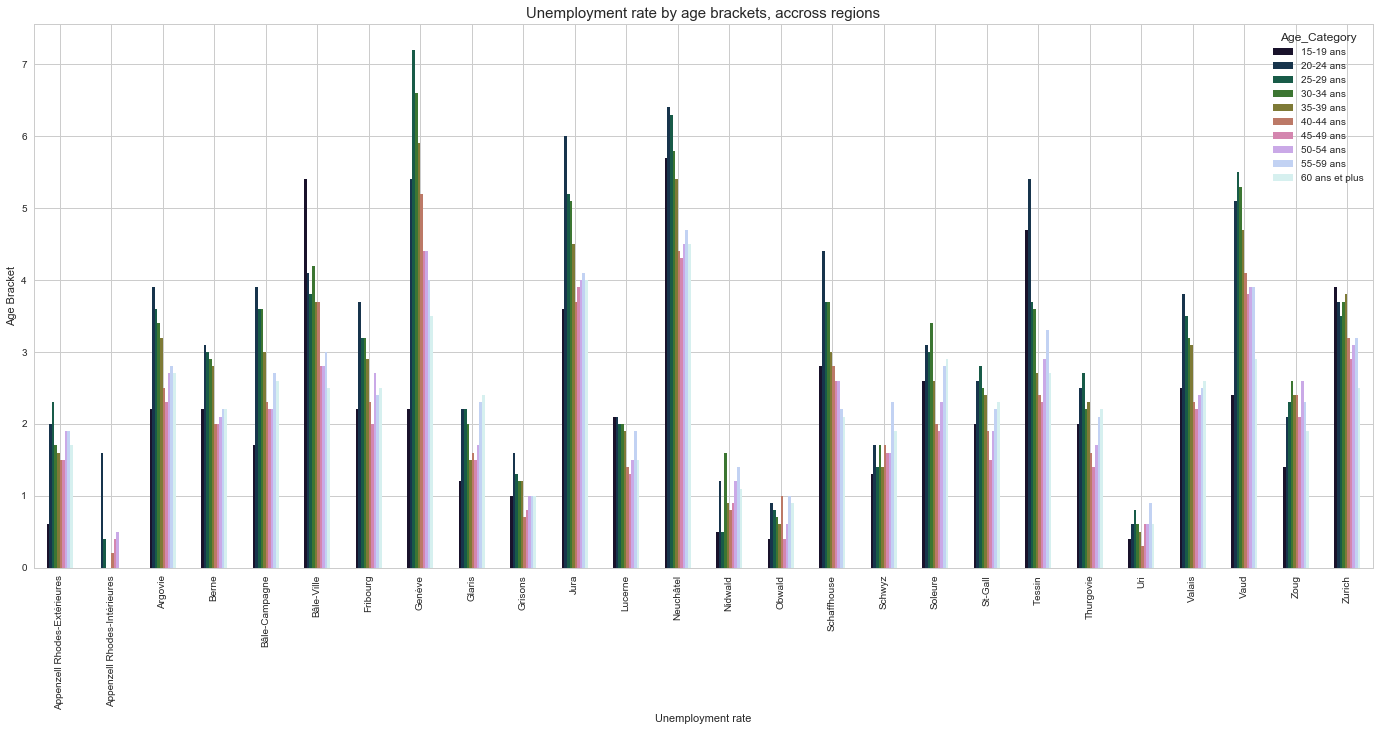

In [11]:
#Plotting and adding info
sns.set_palette('cubehelix',10)
df_pivoted_age.plot.bar(figsize=(24,10))

plt.title('Unemployment rate by age brackets, accross regions',fontsize=15)
plt.ylabel('Age Bracket')
plt.xlabel('Unemployment rate')
plt.show()

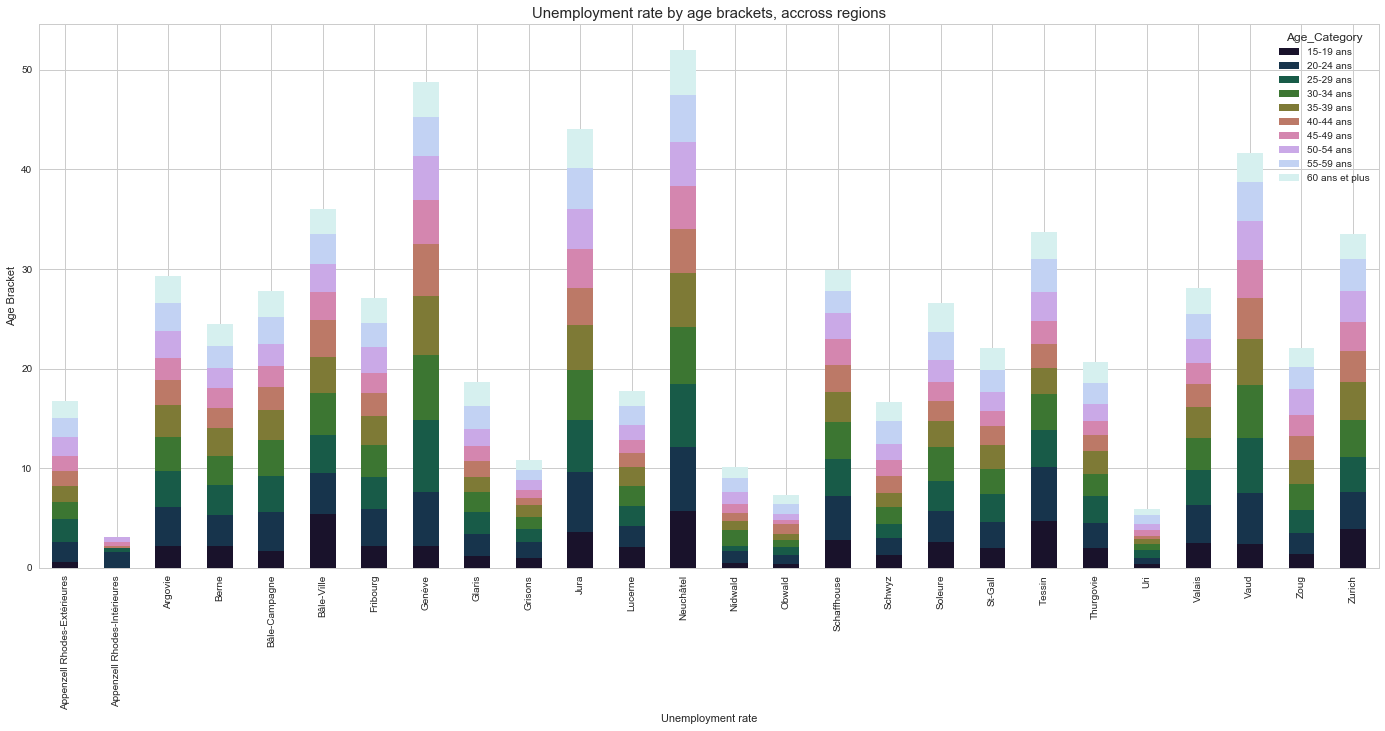

In [12]:
#Plotting and adding info
df_pivoted_age.plot.bar(figsize=(24,10),stacked=True)

plt.title('Unemployment rate by age brackets, accross regions',fontsize=15)
plt.ylabel('Age Bracket')
plt.xlabel('Unemployment rate')
plt.show()

In [15]:
#Plotting and adding info
df_pivoted_age = df_age.reset_index().pivot(index='Age_Category', columns='Canton', values='Unemployement_Rate')
cols = df_pivoted_age.columns.tolist()
cols = [cols[-1]] + cols[:-1]
df_pivoted_age = df_pivoted_age[cols]
brackets = ['15-19 ans', '20-24 ans', '25-29 ans', '30-34 ans', '35-39 ans','40-44 ans', '45-49 ans', '50-54 ans', '55-59 ans', '60 ans et plus']
plt.stackplot(len(cols), (df_pivoted_age.head(len(cols))[brackets]).T)

plt.title('Unemployment rate by age brackets, accross regions',fontsize=15)
plt.ylabel('Age Bracket')
plt.xlabel('Unemployment rate')
plt.show()

KeyError: "['15-19 ans' '20-24 ans' '25-29 ans' '30-34 ans' '35-39 ans' '40-44 ans'\n '45-49 ans' '50-54 ans' '55-59 ans' '60 ans et plus'] not in index"

## Bonus:

Using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [RÃ¶stigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?